# TW Hya Imaging Tutorial

This notebook is a tutorial of synthesis imaging based on the sparse modeling technique using PRIISM. 
**PRIISM** is an imaging tool for radio interferometry based on the sparse modeling technique ([PRIISM](https://github.com/tnakazato/priism): Python Module for Radio Interferometry Imaging with Sparse Modeling). 

In this tutorial, we try synthesis imaging for ALMA interferometry data using interactive PRIISM API for ALMA, `priism.alma`. For batch processing using `priism.runner`, please see `tutorial_hltau.ipynb`.

## Setup and Initialize PRIISM

Before you start this tutorial, you should install PRIISM and packages that PRIISM depends on (casatools, casatasks, etc.). Please see README.md on how to install PRIISM. In addition, you need to install `astropy` because this tutorial uses `astropy` to display final image.

There are two fundamental submodules for imaging, `priism.core` and `priism.alma`, which are mainly for interactive use. For batch mode, we have `priism.runner` submodule. This tutorial is using interactive API provided by `priism.alma`. First of all, we create worker instance for interactive imaging.

In [1]:
import priism.alma
print(f'PRIISM version {priism.__version__}')

worker = priism.alma.AlmaSparseModelingImager(solver='mfista_nufft')

LOG: initialize sakura...
<module 'priism.external.sakura.libsakurapy' from '/Users/nakazato/pyenv/priism/lib/python3.8/site-packages/priism/external/sakura/libsakurapy.so'>
PRIISM version 0.11.5


We make matplotlib figures to be displayed in the notebook.

In [2]:
%matplotlib inline

## ALMA Data : TW Hya

Sample data for the tutorial is the protoplanetary disk "**TW Hydra**" observed at Band 7 with ALMA 12m array (Project 2011.0.00340.S). 
The data infromation is taken in [First Look at Imaging CASA 6](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6), and the data, which is a calibrated measurement set (MS) for CASA, can be downloaded from the link below: 

https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

After you download the data, you should extract the MS from the file. You may run the following cell to obtain the dataset.

In [3]:
%%bash
# download if necessary
[ -e sis14_twhya_calibrated_flagged.ms.tar ] || wget -nv https://bulk.cv.nrao.edu/almadata/public/working/sis14_twhya_calibrated_flagged.ms.tar

# extract MS if it doesn't exist
[ -e sis14_twhya_calibrated_flagged.ms ] || tar xvf sis14_twhya_calibrated_flagged.ms.tar

## Data Preparation

Next, we average visibility channels according to the procedure described in [the CASA Guide](https://casaguides.nrao.edu/index.php?title=First_Look_at_Imaging_CASA_6#Image_the_science_target). This requires `casatasks` that should have been installed as a dependency of PRIISM. We use `twhya_smoothed.ms` in the subsequent steps.

In [4]:
import os
import shutil
from casatasks import listobs, split, rmtables

outputvis = 'twhya_smoothed.ms'
listfile = 'twhya_smoothed.listobs.txt'

# overwrite output data if it exists
rmtables(outputvis)

split(vis='sis14_twhya_calibrated_flagged.ms', field='5', width='8', outputvis=outputvis, datacolumn='data')

data_summary = listobs(outputvis, verbose=True, overwrite=True, listfile=listfile)

# extract spw setup from data summary
os.system(f'grep -E "^Spectral Windows:" -A 2 {listfile}')

Spectral Windows:  (1 unique spectral windows and 1 unique polarization setups)
  SpwID  Name                           #Chans   Frame   Ch0(MHz)  ChanWid(kHz)  TotBW(kHz) CtrFreq(MHz) BBC Num  Corrs  
  0      ALMA_RB_07#BB_2#SW-01#FULL_RES     48   TOPO  372535.223      4882.812    234375.0 372649.9688        2  XX  YY


0

## Data Selection

Next step is to select visibility data to be processed. The `worker` has `selectdata` method for this purpose. Its interface might be familiar with CASA users. You should set MS to `vis`. Also, you should specify name of data column to use with `datacolumn`. `selectdata` accepts major data selection parameters in CASA. Here, we select data with `spw` and `intent`. 

In [5]:
worker.selectdata(vis='twhya_smoothed.ms',
                  spw='0:24',
                  intent='OBSERVE_TARGET#ON_SOURCE',
                  datacolumn='data')

## Image Configuration

Then, image to be created should be configured with `defineimage` function. Again, parameters for it might be familiar with CASA users. Note that `phasecenter` currently accepts field id only. Also, `nchan` should be 1. These limitation may be relaxed in the future. 

In [6]:
worker.defineimage(imsize=[256, 256],
                   cell=['0.08arcsec'],
                   phasecenter='0',  # TW Hya
                   nchan=1,
                   start=0,
                   width=1)

## Read Visibility Data

Configuration has been done. And actual processing starts from here. First processing step is to read MS and load visibility data onto the memory. 

In [7]:
%%timeit -n 1 -r 1

worker.readvis()

***WARN*** refocusing is disabled even if distance to the source is known.


read 200 visibility chunks

DONE reading visibility chunks
5.68 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


read 270 visibility chunks


## Direct Imaging

Now you can create an image from the visibility data. There are two parameters for imaging: `L1` and `Ltsv`. They are hyper parameters for regularization terms. Once you give these parameters, you will obtain one image. For imaging, you should run `solve` to solve the problem and then run `exportimage` to export the solution as FITS image. 

This step may take up to a minute.

In [8]:
%%timeit -n 1 -r 1
%%capture --no-display capture_solve

worker.solve(l1=1e0, ltsv=1e8, maxiter=1000, storeinitialimage=True, scalehyperparam=False)
worker.exportimage(imagename='twhya_b7cont.fits', overwrite=True)

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.09517e+08
lambda_l1:        1
  L1 cost         0
lambda_tsv:       1e+08
  TSV cost        0
total cost        5.47586e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.14029e-05

    1 cost = 54758622.12959, c = 50000000000.00000
   11 cost = 52462580.84038, c = 19277164471.47657
   21 cost = 51649461.65577, c = 7432181401.20717
   31 cost = 51453715.35663, c = 2865427665.05840
   41 cost = 51389090.54457, c = 3151970431.56424
   51 cost = 51370649.55390, c = 3151970431.56424
   61 cost = 51360754.32428, c = 3467167474.72066
   71 cost = 51355467.72160, c = 3151970431.56424
   81 cost = 51352577.74984, c = 3467167474.72066
   91 cost = 51350636.50762, c = 3467167474.72066
  101 cost = 51349338.36022, c = 31519

## Cross-Validation: Finding The Most Reliable Image 

In the previous step, `L1` and `Ltsv` are treated as fixed parameters. In practice, however, these parameters must be optimized to obtain the most reliable image for given visibility data. PRIISM implements a cross validation for optimization. In general, cross validation is time-consuming process because it requires to solve the problem many times and we need to search broad range of `L1-Ltsv` parameter space. This step is a shorthand for  cross validation. We will search only 3x3 parameter space (`L1_list` and `Ltsv_list`) and will perform 4-fold cross validation (default is 10-fold). The most reliable image will be stored in `twhya_b7cont_cv.fits` (i.e., `f'{imageprefix}.fits'`). 

Although this is shorthand, it may take up to 20 minutes or more depending on the machine spec.

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0239e+08
lambda_l1:        1e+06
  L1 cost         61.895
lambda_tsv:       1e+07
  TSV cost        0.0015169
total cost        1.131e+08

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 113104639.95464, c = 50000000000.00000
   11 cost = 81094682.08114, c = 19277164471.47657
   21 cost = 53808139.32956, c = 7432181401.20717
   31 cost = 53788994.38879, c = 2865427665.05840
   41 cost = 53786019.48367, c = 1104746407.60900
   51 cost = 53785903.97190, c = 425927563.97503
   61 cost = 53785845.60681, c = 352006251.21903
   71 cost = 53785840.92439, c = 515372352.40979
   81 cost = 53785838.35164, c = 352006251.21903
   91 cost = 53785837.41111, c = 352006251.21903
  101 cost = 53785837.17056, 

{'L1': 100000.0, 'Ltsv': 100000000.0}

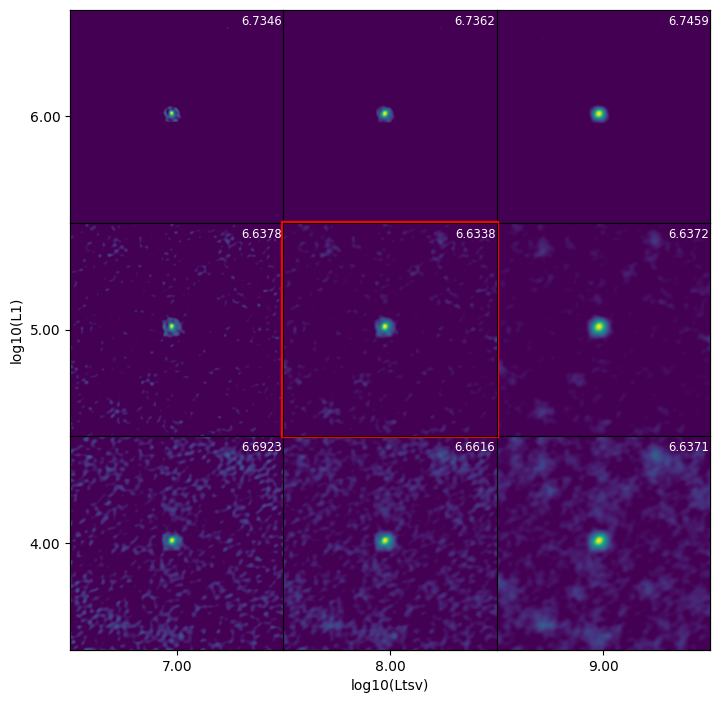

7min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv

L1_list = [1e4, 1e5, 1e6]
Ltsv_list = [1e7, 1e8, 1e9]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cv', imagepolicy='full',
                       summarize=True, figfile='cvresult.png',
                       datafile='cvresult.dat', maxiter=1000, resultasinitialimage=True, scalehyperparam=False)

## Accelerating cross-validation with Bayesian optimization

The `crossvalidation` method has an option to choose optimizer. Default optimizer is `'classical'` which evaluates each pair of `L1` and `Ltsv` in order to find the most reliable combination. In general, `'classical'` optimizer takes time because all combinations of given sets of `L1` and `Ltsv` must be evaluated. This makes practically difficult to seach wide range of `L1` and `Ltsv`. To address this issue, we've introduced another optimizer, `'bayesian'`. The `'bayesian'` optimizer performs Bayesian optimization to reach the most reliable combination with less number of evaluation instead of evaluating individual hyperparameter pairs. Below is an example of obtaining the best result among 12x12 hyperparameters (144 pairs) with up to 15 evaluations, i.e. almost 1/10 of total number of combinations. You will see the same (or close) result to the one obtained by the `'classical'` optimizer. You can choose, or combine, these optimizers as needed to reach the best image. 

Although this is shorthand, it may take up to 20 minutes or more depending on the machine spec.

compute Fourier Transform
Memory allocation and preparations.

Preparation for FFT.Done
Cleaning fftw plan.

  wieghted chi-sq 1.0613e+08
lambda_l1:        10
  L1 cost         0.75909
lambda_tsv:       1000
  TSV cost        8.8585e-05
total cost        5.3065e+07

Memory allocation and preparations.

(OPENMP): Running in multi-thread with 4 threads.

Preparation for FFT. Done.

Computing image with MFISTA using NUFFT.
Stop if iter = 1000 or Delta_cost < 8.1403e-05

    1 cost = 53064819.26425, c = 50000000000.00000
   11 cost = 52177951.23293, c = 19277164471.47657
   21 cost = 51567443.86669, c = 7432181401.20717
   31 cost = 51289303.07265, c = 2865427665.05840
   41 cost = 51154015.72814, c = 3467167474.72066
   51 cost = 51101589.39975, c = 2865427665.05840
   61 cost = 51067196.14080, c = 3467167474.72066
   71 cost = 51042077.94740, c = 3467167474.72066
   81 cost = 51022419.61589, c = 3151970431.56424
   91 cost = 51006098.35378, c = 3151970431.56424
  101 cost = 50992265.3256

{'L1': 100000.0, 'Ltsv': 10000000.0}

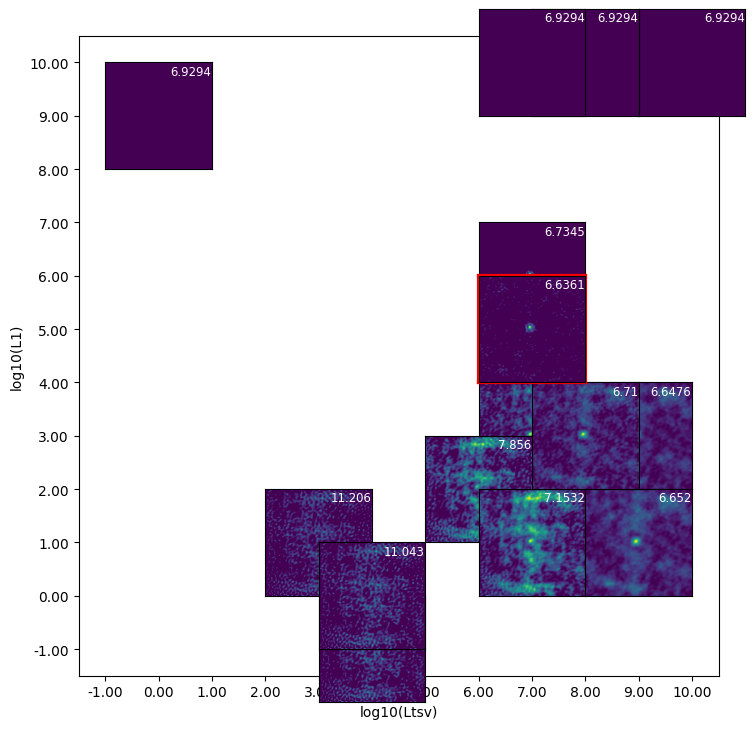

16min 28s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [10]:
%%timeit -n 1 -r 1
%%capture --no-display capture_cv2

L1_list = [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
Ltsv_list =  [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10]
num_fold = 4

worker.crossvalidation(L1_list, Ltsv_list, num_fold=num_fold,
                       imageprefix='twhya_b7cont_cvbayes', imagepolicy='full',
                       summarize=True, figfile='cvresult2.png',
                       datafile='cvresult2.dat', maxiter=1000, resultasinitialimage=False, scalehyperparam=False,
                      optimizer='bayesian', bayesopt_maxiter=15)

## Display Final Image

The created image is displayed here using the `matplotlib` module.
Here, the final image with classical cross-validation is displayed. Only the area of 100&times;100 pixels around central region of the image is shown. 

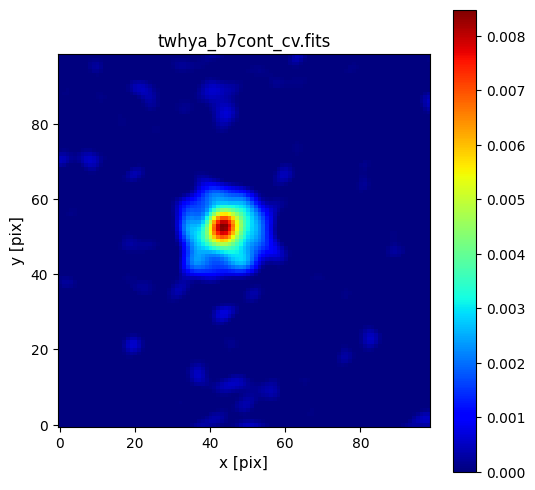

In [11]:
from astropy.io import fits
from matplotlib import pyplot as plt

imname = 'twhya_b7cont_cv.fits'
figname = imname.replace('fits', 'png')

pixs=256; imwd=100; exwd = (pixs-imwd) // 2
_, aa=plt.subplots(1,1, figsize=(6,6))
im=aa.imshow(fits.getdata(imname)[0,0,exwd:((pixs-1)-exwd),exwd:((pixs-1)-exwd)], 
             origin='lower', cmap='jet')
cbar=plt.colorbar(im, ax=aa)
aa.set_title(imname)
aa.set_xlabel("x [pix]",size=11)
aa.set_ylabel("y [pix]",size=11)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.05)
plt.show()